In [4]:
!pip install numpy matplotlib scipy scikit-learn pandas seaborn --quiet

In [2]:
import logging
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up Seaborn for better visuals
sns.set_theme(style="whitegrid")

logger.info("Imports successful")

INFO:__main__:Imports successful


CO 
2
​	
 +4H 
2
​	
 →CH 
4
​	
 +2H 
2
​	
 O

In [7]:


@dataclass
class ReactorSettings:
    molar_mass_CO2: float = 44.01
    molar_mass_H2: float = 2.016
    molar_mass_CH4: float = 16.04
    molar_mass_H2O: float = 18.015
    molar_mass_O2: float = 32
    energy_per_mole_CH4: float = 165  # kJ per mole CH4
    energy_per_mole_H2O: float = 285.8  # kJ per mole H2O

@dataclass
class StorageTank:
    name: str
    capacity: float
    level: float = 0
    is_low: bool = False
    
    def add(self, amount):
        if self.level + amount > self.capacity:
            logger.warning(f"{self.name} tank is full. Cannot add more.")
            self.level = self.capacity
        self.level = min(self.capacity, self.level + amount)
    
    def remove(self, amount):
        if amount > self.level:
            logger.warning(f"Attempting to remove more than available in the {self.name} tank")
        removed = min(self.level, amount)
        self.level -= removed
        if self.level < 0.1 * self.capacity:
            logger.warning(f"{self.name} tank is almost empty. Consider refilling soon.")
            self.is_low = True
        return removed

@dataclass
class PowerSystem:
    solar_max: float
    nuclear: float
    battery_capacity: float
    battery_level: float = 0
    on_duration: int = 12
    off_duration: int = 12

    def available_power(self, hour):
        # Introduce 10% variability to solar power
        variability = np.random.normal(1, 0.1)  # Random variation with mean=1 and stddev=0.1
        solar_power = self.solar_max * variability if (hour % 24) < self.on_duration else 0
        return solar_power + self.nuclear + self.battery_level

    def manage_battery(self, power_used, total_power_available):
        surplus_power = total_power_available - power_used
        if surplus_power > 0:
            self.battery_level = min(self.battery_capacity, self.battery_level + surplus_power)
        else:
            self.battery_level = max(0, self.battery_level - abs(surplus_power))
        return self.battery_level

@dataclass
class SabatierReactor:
    settings: ReactorSettings
    efficiency: float
    catalyst_degradation_rate: float
    temperature_cycle: np.ndarray
    pressure_cycle: np.ndarray
    CO2_tank: StorageTank
    H2_tank: StorageTank
    CH4_tank: StorageTank
    H2O_tank: StorageTank
    power_system: PowerSystem

    def run_cycle(self, hour):
        reaction_efficiency = self.efficiency * (1 - self.catalyst_degradation_rate * hour)
        if reaction_efficiency < 0.1:
            logger.warning(f"Catalyst has degraded beyond acceptable limits. Reactor is not operational at hour {hour}.")
            return {"CH4 Produced (g)": 0, "H2O Produced (g)": 0}, self.power_system
        
        temp_pressure_factor = self.temperature_cycle[hour] * self.pressure_cycle[hour]
        adjusted_efficiency = reaction_efficiency * temp_pressure_factor
        total_power_available = self.power_system.available_power(hour)

        if total_power_available > 0 and self.CO2_tank.level > 0 and self.H2_tank.level > 0:
            result = self.process_reaction(adjusted_efficiency)
            self.store_outputs(result)
            power_used = result["Total Energy Required (kJ)"]
            self.power_system.manage_battery(power_used, total_power_available)
            return result, self.power_system.battery_level
        else:
            logger.warning(f"Insufficient reactants or power to run the Sabatier reactor at hour {hour}.")
            return {"CH4 Produced (g)": 0, "H2O Produced (g)": 0}, self.power_system.battery_level

    def process_reaction(self, efficiency):
        moles_CO2 = self.CO2_tank.remove(44.01) / self.settings.molar_mass_CO2
        moles_H2 = self.H2_tank.remove(8.064) / self.settings.molar_mass_H2
        moles_CH4 = min(moles_CO2, moles_H2 / 4) * efficiency
        return {
            "CH4 Produced (g)": moles_CH4 * self.settings.molar_mass_CH4,
            "H2O Produced (g)": moles_CH4 * 2 * self.settings.molar_mass_H2O,
            "Total Energy Required (kJ)": moles_CH4 * self.settings.energy_per_mole_CH4
        }

    def store_outputs(self, result):
        self.CH4_tank.add(result["CH4 Produced (g)"])
        self.H2O_tank.add(result["H2O Produced (g)"])


@dataclass
class ElectrolysisReactor:
    settings: ReactorSettings
    H2O_tank: StorageTank
    H2_tank: StorageTank
    O2_tank: StorageTank
    power_system: PowerSystem
    efficiency: float = 0.8  # Default efficiency of 80%

    def run_cycle(self, hour):
        if self.H2O_tank.level > 0:
            # Calculate moles of H2O removed and theoretical power required
            moles_H2O = self.H2O_tank.remove(self.settings.molar_mass_H2O) / self.settings.molar_mass_H2O
            hydrogen_produced = moles_H2O * 2 * self.settings.molar_mass_H2  # 2 moles H2 per mole H2O
            oxygen_produced = moles_H2O * self.settings.molar_mass_O2  # 1 mole O2 per mole H2O
            power_required = moles_H2O * self.settings.energy_per_mole_H2O
            
            # Adjust for efficiency losses
            effective_power_required = power_required / self.efficiency
            
            # Check available power with hour-based variability
            total_power_available = self.power_system.available_power(hour)
            if total_power_available >= effective_power_required:
                # Update storage tanks with produced hydrogen and oxygen
                self.H2_tank.add(hydrogen_produced)
                self.O2_tank.add(oxygen_produced)
                
                # Consume the effective power required
                self.power_system.manage_battery(effective_power_required, total_power_available)
                logger.info(f"Electrolysis produced {hydrogen_produced}g H2 and {oxygen_produced}g O2 at hour {hour}.")
                return {
                    "H2 Produced (g)": hydrogen_produced,
                    "O2 Produced (g)": oxygen_produced,
                    "Power Used (kJ)": effective_power_required
                }
            else:
                # Not enough power available for electrolysis
                logger.warning(f"Insufficient power available for electrolysis at hour {hour}.")
                return {"H2 Produced (g)": 0, "O2 Produced (g)": 0, "Power Used (kJ)": 0}
        
        # No H2O available for electrolysis
        logger.warning(f"Insufficient H2O available for electrolysis at hour {hour}.")
        return {"H2 Produced (g)": 0, "O2 Produced (g)": 0, "Power Used (kJ)": 0}


@dataclass
class AtmosphereIntakeSystem:
    name: str
    CO2_tank: StorageTank
    power_system: PowerSystem
    intake_rate: float  # CO2 intake rate in grams per cycle
    power_per_cycle: float  # Power used per cycle in kJ
    interval: int = 6  # Run every 6 hours by default

    def run_cycle(self, hour):
        if hour % self.interval == 0:  # Check if it's time to run intake
            total_power_available = self.power_system.available_power(hour)
            if total_power_available >= self.power_per_cycle:
                # Add CO2 to the tank
                self.CO2_tank.add(self.intake_rate)
                
                # Consume power for the intake process
                self.power_system.manage_battery(self.power_per_cycle, total_power_available)
                
                logger.info(f"Atmosphere intake system ran at hour {hour}: "
                            f"Added {self.intake_rate}g CO2, used {self.power_per_cycle}kJ.")
                return {"CO2 Added (g)": self.intake_rate, "Power Used (kJ)": self.power_per_cycle}
            else:
                # Log warning if not enough power to run intake
                logger.warning("Insufficient power available for atmosphere intake.")
                return {"CO2 Added (g)": 0, "Power Used (kJ)": 0}
        
        # Return zero values if not running this hour
        return {"CO2 Added (g)": 0, "Power Used (kJ)": 0}


# Initialize simulation components
settings = ReactorSettings()
CO2_tank = StorageTank("CO2", capacity=10000, level=5000)
H2_tank = StorageTank("H2", capacity=5000, level=2000)
CH4_tank = StorageTank("CH4", capacity=3000)
H2O_tank = StorageTank("H2O", capacity=2000)
O2_tank = StorageTank("O2", capacity=5000, level=1000)

# Environmental cycles
# Define Mars-specific constants
martian_day_hours = 24.6  # Length of a Martian day in Earth hours
martian_year_days = 687   # Length of a Martian year in Earth days
time_steps_per_day = int(martian_day_hours)  # Simulation time steps per day (1-hour intervals)
time_steps_per_year = martian_year_days * time_steps_per_day  # Total steps for one Martian year

# Simulation duration (e.g., 3 Martian years)
num_years = 0.001
total_time_steps = int(time_steps_per_year * num_years)

# Seasonal Temperature Variation: amplitude over Martian year with a baseline Martian avg temp ~ -60°C
seasonal_temp_variation = 30  # Temperature seasonal swing in degrees Celsius
daily_temp_fluctuation = 40   # Daily swing in degrees Celsius

# Temperature Cycle
seasonal_component = (np.sin(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_temp_variation)
daily_component = (np.sin(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_temp_fluctuation)
temperature_cycle = -60 + seasonal_component + daily_component + np.random.normal(0, 2, total_time_steps)  # Added noise

# Pressure Cycle: Mars surface pressure varies between ~600 Pa to ~1200 Pa across seasons
seasonal_pressure_variation = 300  # Seasonal pressure swing in Pa
daily_pressure_fluctuation = 50    # Daily pressure swing in Pa

# Pressure Cycle
seasonal_component_pressure = (np.cos(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_pressure_variation)
daily_component_pressure = (np.cos(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_pressure_fluctuation)
pressure_cycle = 800 + seasonal_component_pressure + daily_component_pressure + np.random.normal(0, 10, total_time_steps)  # Added noise


# Initialize reactor and intake systems
power_system = PowerSystem(solar_max=500, nuclear=300, battery_capacity=5000)

atmosphere_intake = AtmosphereIntakeSystem(
    name="Martian Atmosphere Intake",
    CO2_tank=CO2_tank,
    power_system=power_system,
    intake_rate=100,      # Example intake rate: 100g of CO2 per cycle
    power_per_cycle=50,   # Example power requirement: 50 kJ per cycle
    interval=2            # Runs every 2 hours
)

sabatier_reactor = SabatierReactor(settings, 0.9, 0.00005, temperature_cycle, pressure_cycle, CO2_tank, H2_tank, CH4_tank, H2O_tank, power_system)

electrolysis_reactor = ElectrolysisReactor(settings, H2O_tank, H2_tank, O2_tank, power_system)


import pandas as pd

# Initialize a dictionary to store simulation data by time step
simulation_data = {
    "CO2_level": [],
    "H2_level": [],
    "CH4_level": [],
    "H2O_level": [],
    "O2_level": [],
    "battery_level": [],
    "power_demand": [],
    "H2_produced": [],
    "O2_produced": [],
    "CO2_added": [],
    "intake_power_demand": [],
    "electrolysis_power_demand": [],
}

for hour in range(total_time_steps):
    logger.info(f"Running simulation for hour {hour}")

    # Run Sabatier reactor cycle
    sabatier_result, battery_level = sabatier_reactor.run_cycle(hour)

    # Run electrolysis reactor cycle
    electrolysis_result = electrolysis_reactor.run_cycle(hour)

    # Run atmosphere intake system cycle
    intake_result = atmosphere_intake.run_cycle(hour)
    
    # Collect data for this time step
    simulation_data["CO2_level"].append(CO2_tank.level)
    simulation_data["H2_level"].append(H2_tank.level)
    simulation_data["CH4_level"].append(CH4_tank.level)
    simulation_data["H2O_level"].append(H2O_tank.level)
    simulation_data["O2_level"].append(O2_tank.level)
    simulation_data["battery_level"].append(battery_level)
    simulation_data["power_demand"].append(sabatier_result.get("Total Energy Required (kJ)", 0) +
                                           electrolysis_result["Power Used (kJ)"] +
                                           intake_result["Power Used (kJ)"])
    simulation_data["H2_produced"].append(electrolysis_result["H2 Produced (g)"])
    simulation_data["O2_produced"].append(O2_tank.level)
    simulation_data["CO2_added"].append(intake_result["CO2 Added (g)"])
    simulation_data["intake_power_demand"].append(intake_result["Power Used (kJ)"])
    simulation_data["electrolysis_power_demand"].append(electrolysis_result["Power Used (kJ)"])

simulation_df = pd.DataFrame(simulation_data)

display(simulation_df.head())
display(simulation_df.tail())

INFO:__main__:Running simulation for hour 0
INFO:__main__:Atmosphere intake system ran at hour 0: Added 100g CO2, used 50kJ.
INFO:__main__:Running simulation for hour 1
INFO:__main__:Running simulation for hour 2
INFO:__main__:Atmosphere intake system ran at hour 2: Added 100g CO2, used 50kJ.
INFO:__main__:Running simulation for hour 3
INFO:__main__:Running simulation for hour 4
INFO:__main__:Atmosphere intake system ran at hour 4: Added 100g CO2, used 50kJ.
INFO:__main__:Running simulation for hour 5
INFO:__main__:Running simulation for hour 6
INFO:__main__:Atmosphere intake system ran at hour 6: Added 100g CO2, used 50kJ.
INFO:__main__:Running simulation for hour 7
INFO:__main__:Running simulation for hour 8
INFO:__main__:Atmosphere intake system ran at hour 8: Added 100g CO2, used 50kJ.
INFO:__main__:Running simulation for hour 9
INFO:__main__:Running simulation for hour 10
INFO:__main__:Atmosphere intake system ran at hour 10: Added 100g CO2, used 50kJ.
INFO:__main__:Running simula

,CO2_level,H2_level,CH4_level,H2O_level,O2_level,battery_level,power_demand,H2_produced,O2_produced,CO2_added,intake_power_demand,electrolysis_power_demand
0,5055.99,1991.936,-1.031179e+06,-2.316294e+06,1000,5000,-1.060746e+07,0,1000,100,50,0
1,5011.98,1983.872,-1.844300e+06,-4.142776e+06,1000,5000,-8.364405e+06,0,1000,0,0,0
2,5067.97,1975.808,-2.518726e+06,-5.657712e+06,1000,5000,-6.937625e+06,0,1000,100,50,0
3,5023.96,1967.744,-3.022379e+06,-6.789047e+06,1000,5000,-5.180967e+06,0,1000,0,0,0
4,5079.95,1959.680,-3.333230e+06,-7.487299e+06,1000,5000,-3.197605e+06,0,1000,100,50,0


,CO2_level,H2_level,CH4_level,H2O_level,O2_level,battery_level,power_demand,H2_produced,O2_produced,CO2_added,intake_power_demand,electrolysis_power_demand
11,5071.88,1903.232,-6.800198e+06,-1.527501e+07,1000,5000,-8.671054e+06,0,1000,0,0,0
12,5127.87,1895.168,-7.791719e+06,-1.750222e+07,1000,5000,-1.019951e+07,0,1000,100,50,0
13,5083.86,1887.104,-8.973300e+06,-2.015636e+07,1000,5000,-1.215467e+07,0,1000,0,0,0
14,5139.85,1879.040,-1.024020e+07,-2.300215e+07,1000,5000,-1.303232e+07,0,1000,100,50,0
15,5095.84,1870.976,-1.167757e+07,-2.623084e+07,1000,5000,-1.478584e+07,0,1000,0,0,0


2H 
2
​	
 O→2H 
2
​	
 +O 
2
​	
 

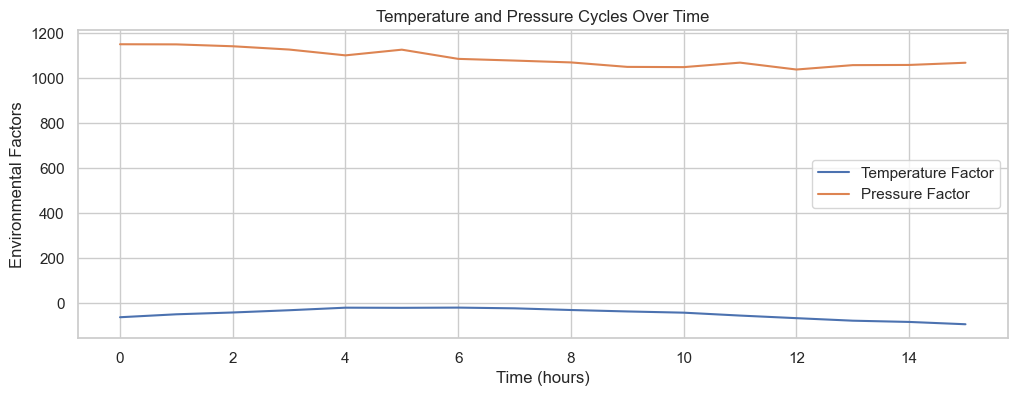

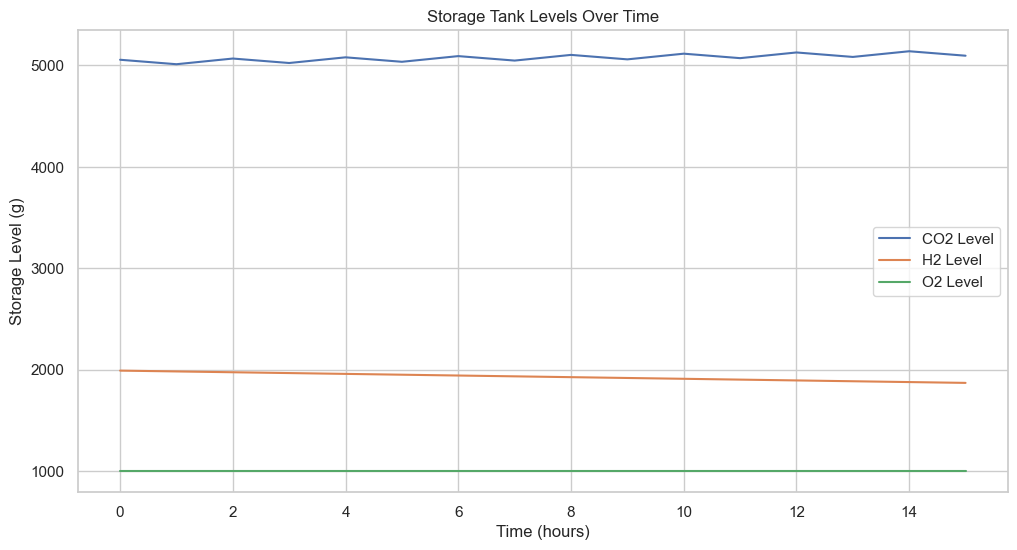

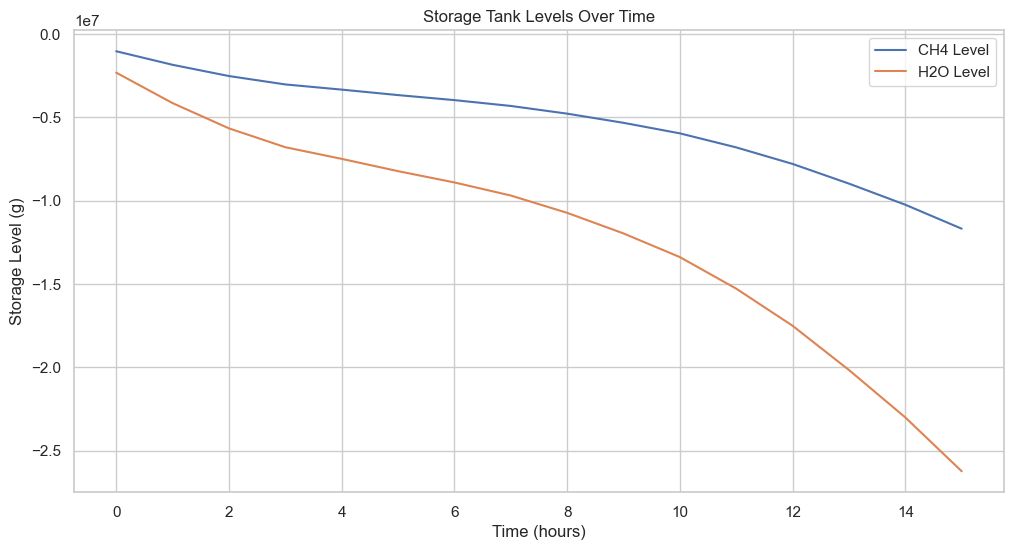

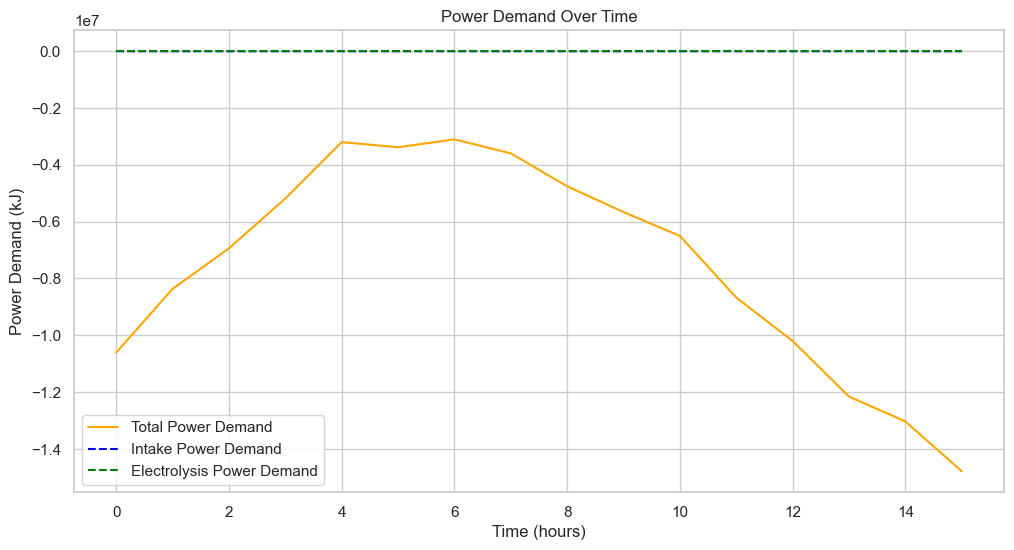

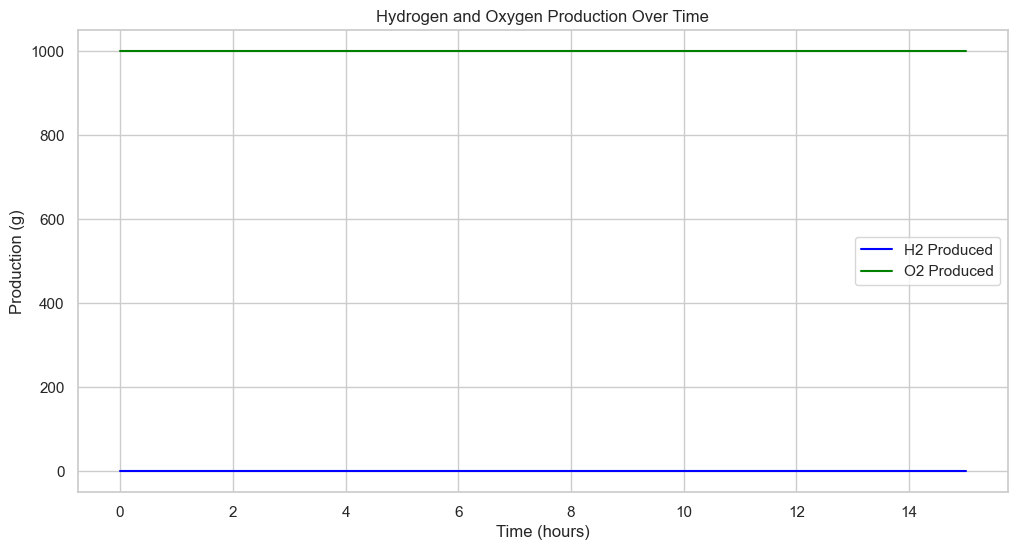

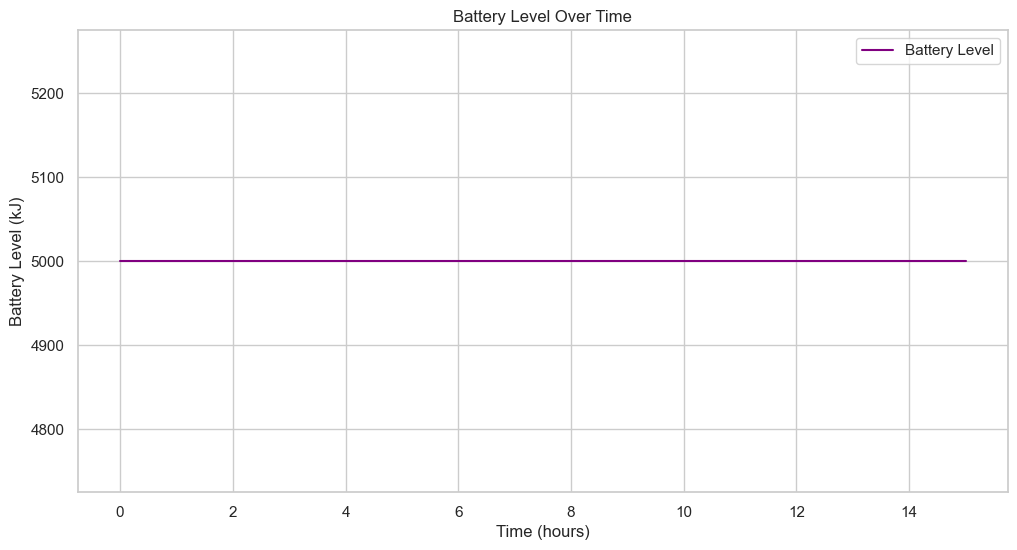

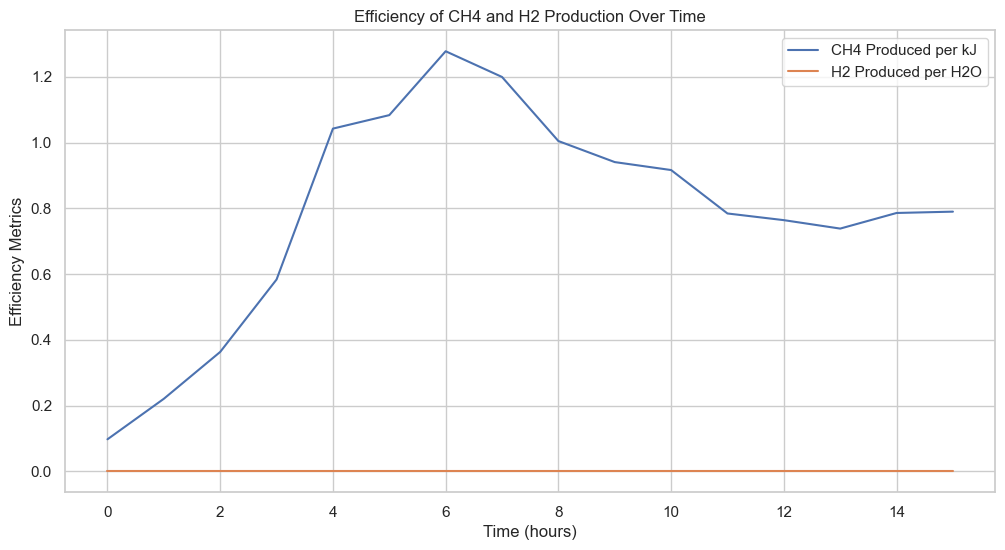

In [9]:
plt.figure(figsize=(12, 4))
sns.lineplot(temperature_cycle, label='Temperature Factor')
sns.lineplot(pressure_cycle, label='Pressure Factor')
plt.xlabel("Time (hours)")
plt.ylabel("Environmental Factors")
plt.title("Temperature and Pressure Cycles Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CO2_level"], label='CO2 Level')
plt.plot(simulation_df["H2_level"], label='H2 Level')
plt.plot(simulation_df["O2_level"], label='O2 Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CH4_level"], label='CH4 Level')
plt.plot(simulation_df["H2O_level"], label='H2O Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["power_demand"], label='Total Power Demand', color='orange')
plt.plot(simulation_df["intake_power_demand"], label='Intake Power Demand', color='blue', linestyle='dashed')
plt.plot(simulation_df["electrolysis_power_demand"], label='Electrolysis Power Demand', color='green', linestyle='dashed')
plt.xlabel("Time (hours)")
plt.ylabel("Power Demand (kJ)")
plt.title("Power Demand Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["H2_produced"], label='H2 Produced', color='blue')
plt.plot(simulation_df["O2_produced"], label='O2 Produced', color='green')
plt.xlabel("Time (hours)")
plt.ylabel("Production (g)")
plt.title("Hydrogen and Oxygen Production Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["battery_level"], label='Battery Level', color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Battery Level (kJ)")
plt.title("Battery Level Over Time")
plt.legend()
plt.show()

simulation_df['CH4_per_kJ'] = simulation_df['CH4_level'] / simulation_df['power_demand']
simulation_df['H2_per_H2O'] = simulation_df['H2_produced'] / simulation_df['H2O_level']
plt.figure(figsize=(12, 6))
sns.lineplot(data=simulation_df, x=simulation_df.index, y="CH4_per_kJ", label="CH4 Produced per kJ")
sns.lineplot(data=simulation_df, x=simulation_df.index, y="H2_per_H2O", label="H2 Produced per H2O")
plt.xlabel("Time (hours)")
plt.ylabel("Efficiency Metrics")
plt.title("Efficiency of CH4 and H2 Production Over Time")
plt.legend()
plt.show()